# Coronavirus (SARS-nCOV-2) Graphing Utility - CSI Quarter Project
## Copyright (C) 2020  Dev Singh

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Based on data from [John Hopkins University CSSE](https://github.com/CSSEGISandData/COVID-19/)
### Sources consulted: 
https://gist.github.com/andrewgiessel/5684769

https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/activation.py

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

https://www.itl.nist.gov/div898/software/dataplot/refman1/ch3/spline_f.pdf

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
import scipy.misc as m
import scipy.optimize as o
import os
import io
import functools as ft
from scipy.interpolate import UnivariateSpline

In [2]:
config = {
    "countries": ["China","Germany", "US"], # which countries to plot
    "exp-fit-country": True, # should sigmoidal fitting be applied to the countries
    "label-points": False, # WARNING: ENABLING WILL MAKE THE GRAPH VERY CLUTTERED! ONLY RECCOMENDED IF YOU ARE PLOTTING JUST ONE COUNTRY
    "dataset": "confirmed" # which dataset to use. Available datasets: confirmed, deaths, and recovered
}

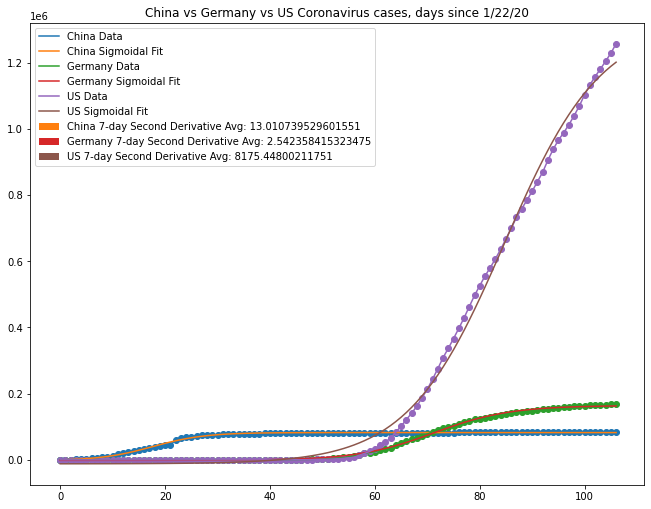

Done! View the figures generated in the root folder. If you are using JupyterLab/Notebook, the figure will appear below.


<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_" + config['dataset'] + "_global.csv")

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

for country in config["countries"]:
    country_data = []
    x_pred = []
    y_pred = []
    if country == "World":
        country_data = df.loc[df["Lat"] != 0].T[4:].T.sum().to_frame()
    elif country == "US":
        country_data = df.loc[df["Country/Region"] == "US"].T[4:].T.sum().to_frame()
    else:
        country_data = df.loc[df["Country/Region"] == country].T[4:].T.sum().to_frame()
    country_dates = country_data.T.columns.to_numpy()
    country_data = country_data.T.to_numpy()
    x = np.array(list(range(0, len(country_dates))))
    y = np.array(list(country_data[0]))
    pred_y_country = []
    if config["exp-fit-country"] == True:
        popt, pcov = o.curve_fit(sigmoid, x, y ,p0 = (max(y), np.median(x),1,min(y)))    
        x_pred = np.array(list(range(0, len(country_dates))))
        y_pred = sigmoid(x_pred, *popt)

    ## Plotting
    title = ft.reduce(lambda x, y: x + (" vs " if x else "") + y, config['countries'], "")
    plt.title(title + " Coronavirus cases, days since " + str(country_dates[0]))
    if config["label-points"] == True:    
        for x1,y1 in zip(x,country_data[0]):
            plt.annotate(y1, 
                         (x1,y1),
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center')
    # Calculate second derivative with spline
    y_spl = UnivariateSpline(x,country_data[0],s=0)
    x_range = np.linspace(country_data[0][0],x[-1],1000)
    y_spl_2d = y_spl.derivative(n=2)
    avg_2d = (ft.reduce(lambda x, y:x+y, y_spl_2d(x_range)[-7:]) / 7) # 5 day average 2nd derivative
    
    # plot the countries data
    plt.scatter(x, country_data[0])
    plt.plot(x, country_data[0], label= country + " Data")
    plt.bar(0,0,label=country + " 7-day Second Derivative Avg: " + str(avg_2d))
    if config["exp-fit-country"] == True:
        plt.plot(x_pred, y_pred, label=country + " Sigmoidal Fit")
    fig = plt.gcf()
    fig.set_size_inches(11, 8.5)
country = ft.reduce(lambda x, y: x + ("." if x else "") + y, config['countries'], "") # Get all the countries that were plotted for saving to file. 
plt.legend(loc="best")
fig.savefig((config["dataset"] + '_' + country + "." + country_dates[len(country_dates) - 1] + ".png").replace("/", "-"), dpi=100)
plt.show()
plt.clf()
print("Done! View the figures generated in the root folder. If you are using JupyterLab/Notebook, the figure will appear above.")